In [1]:
import kagglehub
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy

from IPython.display import clear_output

Eliminate potential sources of non-reapitability

In [2]:
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

seed = 1957
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

**1) Selecting the dataset**

We selected the heart.csv data set to practice classification

In [3]:
DF = pd.read_csv(R"C:\Users\User\Documents\jupyter\DeepLearning/Project/heart.csv")

**2) EDA**

*****Investigation the content of the dataset*****

Get a list of the columns of the dataset

In [4]:
print ('the columns of the dataset are')
print ('------------------------------')
print(DF.columns)

the columns of the dataset are
------------------------------
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


Following is a description of the data-set columns, atken from Kaggle

| Variable Name | Description | Values/Notes |
|:-------------|:------------|:------------|
| **age** | Age of the patient | (years) |
| **sex** | Gender | 1 = male, 0 = female |
| **cp** | Chest pain type | 0: Typical angina<br>1: Atypical angina<br>2: Non-anginal pain<br>3: Asymptomatic |
| **trestbps** | Resting blood pressure | (mm Hg) |
| **chol** | Serum cholesterol | (mg/dl) |
| **fbs** | Fasting blood sugar | 1 = true, 0 = false |
| **restecg** | Resting ECG results | 0: Normal<br>1: ST-T wave abnormality<br>2: Left ventricular hypertrophy |
| **thalach** | Max heart rate achieved | (bpm) |
| **exang** | Exercise-induced angina | 1 = yes, 0 = no |
| **oldpeak** | ST depression (exercise vs. rest) | (numeric) |
| **slope** | Slope of peak exercise ST segment | 0: Upsloping<br>1: Flat<br>2: Downsloping |
| **ca** | Major vessels colored by fluoroscopy | (0–3) |
| **thal** | Thalassemia | 0: Normal<br>1: Fixed defect<br>2: Reversible defect |
| **target** | Heart disease diagnosis | 0: No significant disease<br>1: Significant disease |

*****Check for missing values*****

In [5]:
if not(DF.isnull().values.any()):
    print ('There are no missing values')
else:
    print ('There are some missing values')

There are no missing values


*****Checking the data type of variables*****

In [6]:
if not len(DF.select_dtypes(exclude=['number']).columns):
    print ('All columns are numeric')
else:
    print ('Some columns are not numeric')

All columns are numeric


Note: the data type of all variables is numeric, but most of them are categorial in nature, as described above

*****Investigate the correlation between the variables*****

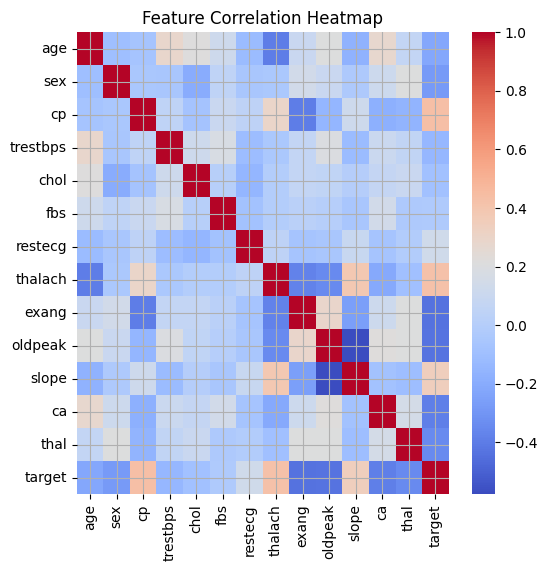

In [7]:
plt.figure(figsize=(6,6))
sns.heatmap(DF.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.grid()
plt.title("Feature Correlation Heatmap")
plt.show()

Evaluate the level of correlation between the predictors and the target

In [8]:
target_corr = DF.corr()['target'].drop('target')
sorted_target_corr = target_corr.loc[target_corr.abs().sort_values(ascending=False).index]
print ('variable   correlation with target')
print(sorted_target_corr)
# print(target_corr.loc[target_corr.abs().sort_values(ascending=False).index])

variable   correlation with target
exang      -0.436757
cp          0.433798
oldpeak    -0.430696
thalach     0.421741
ca         -0.391724
slope       0.345877
thal       -0.344029
sex        -0.280937
age        -0.225439
trestbps   -0.144931
restecg     0.137230
chol       -0.085239
fbs        -0.028046
Name: target, dtype: float64


The predictors exang, cp, oldpeak, and thalach have moderate correlation with the target.   
The predictors ca, slope, thal, sex, and age have week correlation with the target.   
The predictors trestbps, restecg, chol, and fbs have essentially no correlation with the target

Check for potential colinearity between the predictors

In [9]:
predictors = DF.drop('target',axis=1)
corr_matrix = predictors.corr()
sorted_corr = (corr_matrix.abs().unstack().sort_values(ascending=False))
sorted_corr1 = sorted_corr[sorted_corr.index.get_level_values(0) != sorted_corr.index.get_level_values(1)]
sorted_corr2 = sorted_corr1[::2]
print('The pairs with the highest correlation are')
print('------------------------------------------')
print('var1   var2       correlation')
print(sorted_corr2.head())

The pairs with the highest correlation are
------------------------------------------
var1   var2       correlation
slope  oldpeak    0.577537
age    thalach    0.398522
cp     exang      0.394280
slope  thalach    0.386784
exang  thalach    0.378812
dtype: float64


Exept from the slope-oldpeak pair, which maight be considerred to have almost moderate colinearity, all other pairs have low or acceptable collinearity.

*****Checking the balance of the target*****

In [10]:
y = DF['target']
print(f'The positive outcome rate is {y.mean():.2f}')

The positive outcome rate is 0.54


The target is well balanced

**3) Preprocessing**

*****Scaling (normalization)*****

Most of the predictors are categorial. The only numeric predictors are: age, trestbps, oldpeak, and ca. 

Scale the numeric predictors to the 0 to 1 interval

In [11]:
X_unencoded = predictors.copy()
numeric_predictors = ['age','trestbps','oldpeak'] 
scaler=scaler = MinMaxScaler(feature_range=(0,1))
X_unencoded[numeric_predictors]=scaler.fit_transform(predictors[numeric_predictors])

Most of the categorial predictors are binary. The non-binary categorial perdictors are: cp, restecg, slope, and thal      

Encode the non-binary categorial predictoy in a one hop encoding

In [12]:
non_binary_categorial_predictors = ['cp','restecg','slope','thal'] 
X=pd.get_dummies(X_unencoded,columns=non_binary_categorial_predictors,drop_first=True)

**4) Splitting into train, validation, and test**

Split the dataset into train(60%), validation(20%), and test(20%).

In [13]:
X_train, X_full_test, y_train, y_full_test = train_test_split(X, y, test_size=0.4,random_state=503)
X_val, X_test, y_val,y_test = train_test_split(X_full_test, y_full_test, test_size=0.5,random_state=419)

**5) Getting reference for the expected performance by using ML algorithms (XGBC,RF, and LR)**

*****XGBClassifier*****

In [14]:
XGBC_model = xgb.XGBClassifier()
XGBC_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
y_pred = XGBC_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f'train Accuracy: {accuracy:.3}')
y_pred = XGBC_model.predict(X_test)
XGBC_test_accuracy = accuracy_score(y_test, y_pred)
print(f'test Accuracy:  {XGBC_test_accuracy:.3}')

train Accuracy: 1.0
test Accuracy:  0.77


*****RF (random forest)*****

In [16]:
RF_model=RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
y_pred = RF_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f'train Accuracy: {accuracy:.3}')
y_pred = RF_model.predict(X_test)
RF_test_accuracy = accuracy_score(y_test, y_pred)
print(f'test Accuracy:  {RF_test_accuracy:.3}')

train Accuracy: 1.0
test Accuracy:  0.836


*****LR (logistic regression classifier)*****

In [18]:
LR_model = LogisticRegression(max_iter=10000000)  # Increase max_iter if needed
LR_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000000)

In [19]:
y_pred = LR_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f'train Accuracy: {accuracy:.3}')
y_pred = LR_model.predict(X_test)
LR_test_accuracy = accuracy_score(y_test, y_pred)
print(f'test Accuracy:  {LR_test_accuracy:.3}')

train Accuracy: 0.867
test Accuracy:  0.803


*****Compare the tree ML models and select the best one*****

In [20]:
print(f'Logistic regression accuracy: {LR_test_accuracy:.3}')
print(f'Random forest accuracy:       {RF_test_accuracy:.3}')
print(f'XGBC accuracy:                {XGBC_test_accuracy:.3}')

Logistic regression accuracy: 0.803
Random forest accuracy:       0.836
XGBC accuracy:                0.77


Random forest gives the best performances (in terms of accuracy).   
We shall use the performances of the random tree for comparison with ANN

**6) Examining the performances of the selected ML algorithms (RF) with regard to various metrics** 

The evaluation is performed with regrd to accuracy, recall, precision, and F1

In [21]:
y_pred = RF_model.predict(X_test)
RF_acc = accuracy_score(y_test, y_pred)
RF_prec = precision_score(y_test, y_pred)
RF_rec = recall_score(y_test, y_pred)
RF_f1 = f1_score(y_test, y_pred)
print('Evaluation Metrics of the RF model')
print('----------------------------------')
print(f"Accuracy:  {RF_acc:.4f}")
print(f"Recall:    {RF_rec:.4f}")
print(f"Precision: {RF_prec:.4f}")
print(f"F1-Score:  {RF_f1:.4f}")

Evaluation Metrics of the RF model
----------------------------------
Accuracy:  0.8361
Recall:    0.9062
Precision: 0.8056
F1-Score:  0.8529


**7) Applying a basic ANN**

Define a callback to restore the weights to the ephoc with the best validation loss

In [22]:
class BestWeightSaver(Callback):
    def __init__(self, monitor='val_loss'):
        super().__init__()
        self.monitor = monitor
        self.best_weights = None
        self.best = np.Inf
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1  # Save the epoch number (human-readable, starting at 1)
#            print(f"Best {self.monitor} improved to {self.best:.4f} at epoch {self.best_epoch}")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best weights from epoch {self.best_epoch} with {self.monitor}: {self.best:.4f}")
best_weight_saver = BestWeightSaver(monitor='val_loss')

*****Training the basic model*****

The basic ANN is comprises a single hidden layer with 64 neurons.   
The activation function of the hidden layer is ReLU.   
The activation function of the output layer is sigmoid.   
The loss function used for training is binary-cross-entropy.      
The weights are restored to the epoch with the best validation loss

In [23]:
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
BNN_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
])
BNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_history = BNN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),verbose=0,callbacks=[best_weight_saver])

Restored best weights from epoch 43 with val_loss: 0.4472


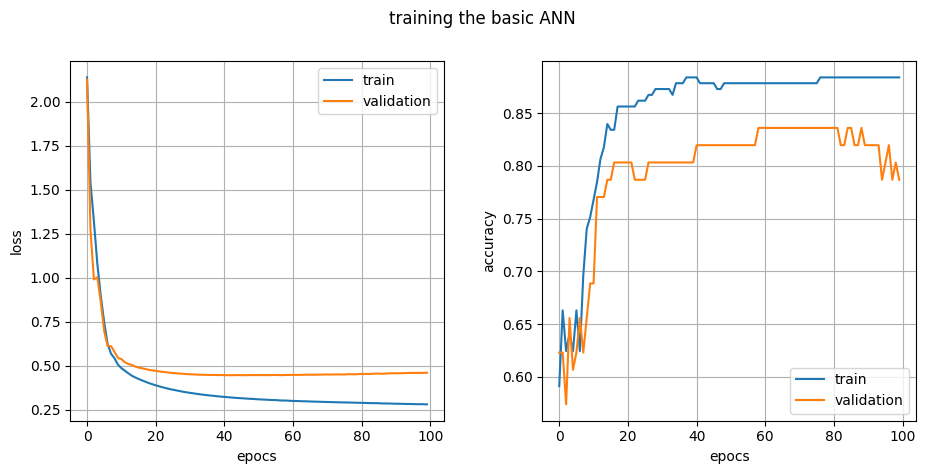

In [24]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
fig.tight_layout(pad=4.0)
ax = axes[0]
ax.plot(BNN_history.history['loss'], label='train')
ax.plot(BNN_history.history['val_loss'], label='validation')
ax.grid()
ax.legend()
ax.set_xlabel('epocs')
ax.set_ylabel('loss')
ax=axes[1]
ax.plot(BNN_history.history['accuracy'], label='train')
ax.plot(BNN_history.history['val_accuracy'], label='validation')
ax.grid()
ax.legend()
ax.set_xlabel('epocs')
ax.set_ylabel('accuracy')
plt.suptitle('training the basic ANN')
plt.show()

*****Evaluating the performances of the basic model, with respect to various metrics, over the validation set*****

In [25]:
decision_threshold = 0.5
y_pred_val = BNN_model.predict(X_val)
y_dec_val = y_pred_val>=decision_threshold
BNN_acc_val =   accuracy_score  (y_val, y_dec_val)
BNN_rec_val =   recall_score    (y_val, y_dec_val)
BNN_prec_val =  precision_score (y_val, y_dec_val)
BNN_f1_val =    f1_score        (y_val, y_dec_val)
print('metric    value')
print('----------------------------------------')
print(f"Accuracy    {BNN_acc_val:.2f}")
print(f"Recall      {BNN_rec_val:.2f}")
print(f"Precision   {BNN_prec_val:.2f}")
print(f"F1-Score    {BNN_f1_val:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
metric    value
----------------------------------------
Accuracy    0.82
Recall      0.84
Precision   0.82
F1-Score    0.83


**8) comparing the performances of the basic ANN calassifer with those of the RF classifier**

The comparisoon is performed with regard to the accuracy, recall, precision and F1 metrics   
The comparison is performed over the test set

In [26]:
decision_threshold = 0.5
y_pred_test = BNN_model.predict(X_test)
y_dec_test = y_pred_test>=decision_threshold
BNN_acc_test =   accuracy_score  (y_test, y_dec_test)
BNN_rec_test =   recall_score    (y_test, y_dec_test)
BNN_prec_test =  precision_score (y_test, y_dec_test)
BNN_f1_test =    f1_score        (y_test, y_dec_test)
print('metric      FR     basic ANN')
print('----------------------------------------')
print(f"Accuracy    {RF_acc:.2f}   {BNN_acc_test:.2f}")
print(f"Recall      {RF_rec:.2f}   {BNN_rec_test:.2f}")
print(f"Precision   {RF_prec:.2f}   {BNN_prec_test:.2f}")
print(f"F1-Score    {RF_f1:.2f}   {BNN_f1_test:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
metric      FR     basic ANN
----------------------------------------
Accuracy    0.84   0.82
Recall      0.91   0.91
Precision   0.81   0.78
F1-Score    0.85   0.84


The of the basic NN model is slightly worse than those of the RF model.  

**9) Investigate the effect of some hyperparameters of the performances of the ANN**

The hyperparameters to be checked are the depth, width, and activation functions   

*****Width of the hidden layer*****

Evaluating networks with hidden layer values of 20,30,40,60,80, and 100 neurons
The figure of merit for the evaluation is the loss over the validation set.  

In [27]:
single_layer_history_list = [] 
N1_values = [20,30,40,60,80,100]
for indx in range(len(N1_values)):
    seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
    best_weight_saver = BestWeightSaver()
    N1=N1_values[indx]
    print('N1 = ',N1)
    single_layer_model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),  # Input layer
        layers.Dense(N1, activation='relu'),  # Hidden layer
        layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
        ])
    single_layer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    single_layer_history = single_layer_model.fit(X_train, y_train, epochs=150, batch_size=32,validation_data=(X_val, y_val),
                                                  verbose=0,callbacks=[best_weight_saver])
    single_layer_history_list.append(single_layer_history)

N1 =  20
Restored best weights from epoch 120 with val_loss: 0.4323
N1 =  30
Restored best weights from epoch 106 with val_loss: 0.4491
N1 =  40
Restored best weights from epoch 83 with val_loss: 0.4351
N1 =  60
Restored best weights from epoch 30 with val_loss: 0.4184
N1 =  80
Restored best weights from epoch 57 with val_loss: 0.4256
N1 =  100
Restored best weights from epoch 37 with val_loss: 0.4359


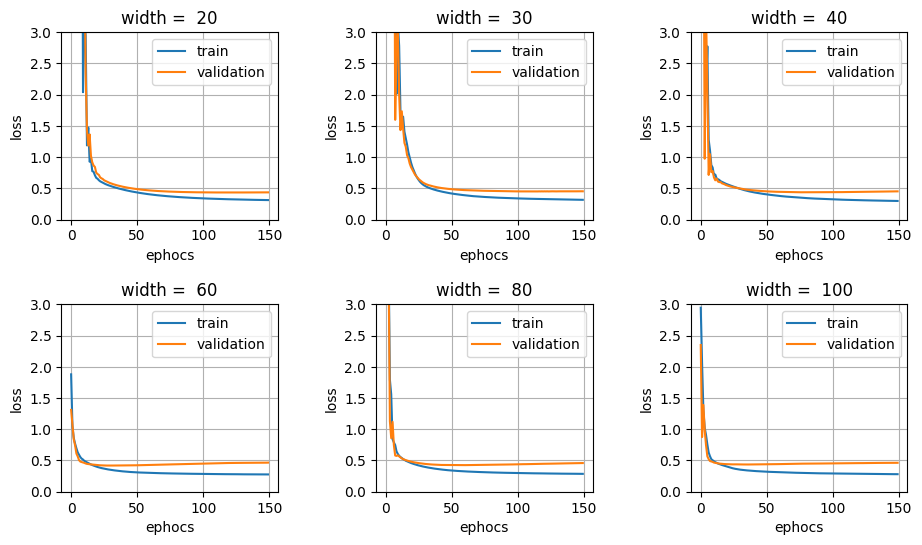

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout(pad=4.0)
for indx in range(len(N1_values)):
    N1=N1_values[indx]
    ax = axes[indx//3, indx%3]
    train_loss = single_layer_history_list[indx].history['loss']
    val_loss = single_layer_history_list[indx].history['val_loss']
    ax.plot(train_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_ylim([0, 3])   
    ax.grid()
    ax.legend()
    ax.set_xlabel('ephocs')
    ax.set_ylabel('loss')
    ax.set_title(f'width =  {N1}')
plt.show() 

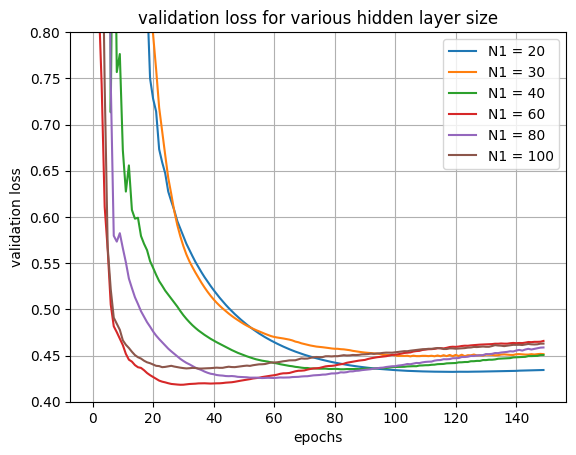

In [29]:
plt.figure()
for indx in range(len(N1_values)):
    N1=N1_values[indx]
    val_loss = single_layer_history_list[indx].history['val_loss']
    plt.plot(val_loss,label=f'N1 = {N1}')
plt.grid()
plt.legend()
plt.ylim(0.4,0.8)
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.title(f'validation loss for various hidden layer size')
plt.show() 

N1=60 is the best choice.   

In [30]:
best_N1 = 60

In [31]:
N1 = best_N1
print('N1 = ', N1)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
best_single_layer_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
best_single_layer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_single_layer_history = best_single_layer_model.fit(X_train, y_train, epochs=75, batch_size=32,validation_data=(X_val, y_val),
                                                  verbose=0,callbacks=[best_weight_saver])

N1 =  60
Restored best weights from epoch 30 with val_loss: 0.4184


In [32]:
decision_threshold = 0.5
y_pred_test = best_single_layer_model.predict(X_test)
y_dec_test = y_pred_test>=decision_threshold
best_single_layer_acc_test =   accuracy_score  (y_test, y_dec_test)
best_single_layer_rec_test =   recall_score    (y_test, y_dec_test)
best_single_layer_prec_test =  precision_score (y_test, y_dec_test)
best_single_layer_f1_test =    f1_score        (y_test, y_dec_test)
print('best single layer model test preformances')
print('metric      value')
print('-----------------')
print(f"Accuracy    {BNN_acc_test:.2f}")
print(f"Recall      {BNN_rec_test:.2f}")
print(f"Precision   {BNN_prec_test:.2f}")
print(f"F1-Score    {BNN_f1_test:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
best single layer model test preformances
metric      value
-----------------
Accuracy    0.82
Recall      0.91
Precision   0.78
F1-Score    0.84


*****Depth of the network*****

******Two hidden layers model******

Adding a second hidden layer with various widths: 4,6,8,10,12

In [33]:
two_layers_history_list = []
N1 = best_N1
N2_values = [4,6,8,10,12]
for indx in range(len(N2_values)):
    N2=N2_values[indx]
    print('N2 = ',N2)
    seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
    best_weight_saver = BestWeightSaver()
    two_layers_model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),  # Input layer
        layers.Dense(N1, activation='relu'),  # first hidden layer
        layers.Dense(N2, activation='relu'),  # second hidden layer
        layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
    two_layers_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    two_layers_history = two_layers_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val),
                                              verbose=0,callbacks=[best_weight_saver])
    two_layers_history_list.append(two_layers_history)

N2 =  4
Restored best weights from epoch 55 with val_loss: 0.4266
N2 =  6
Restored best weights from epoch 74 with val_loss: 0.4243
N2 =  8
Restored best weights from epoch 44 with val_loss: 0.4260
N2 =  10
Restored best weights from epoch 66 with val_loss: 0.4183
N2 =  12
Restored best weights from epoch 62 with val_loss: 0.4461


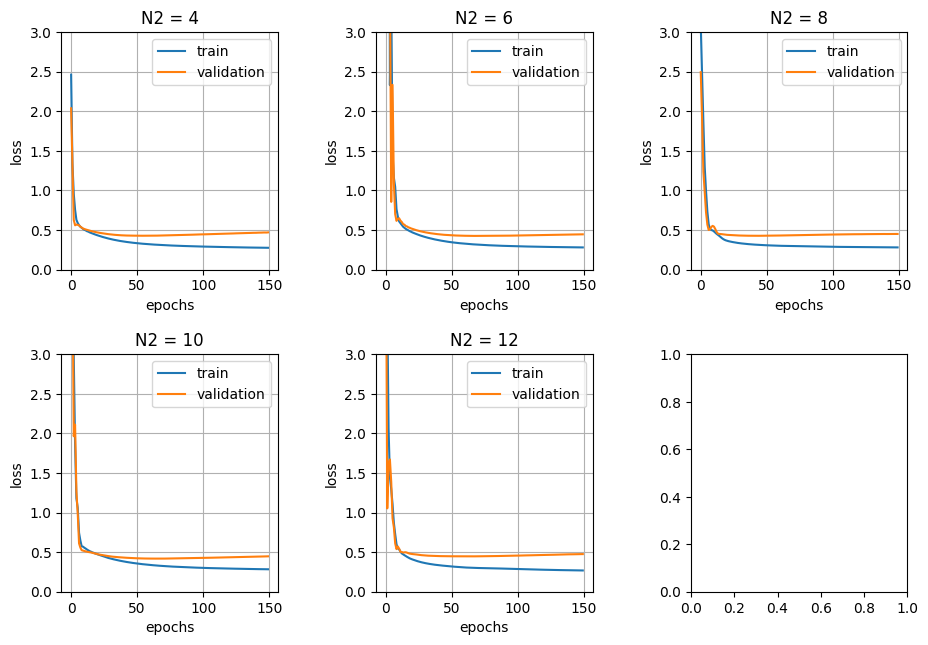

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.tight_layout(pad=4.0)
for indx in range(len(N2_values)):
    N2=N2_values[indx]
    ax = axes[indx//3, indx%3]
    train_loss = two_layers_history_list[indx].history['loss']
    val_loss = two_layers_history_list[indx].history['val_loss']
    ax.plot(train_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_ylim([0, 3])
    ax.grid()
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_title(f'N2 = {N2}')
plt.show() 

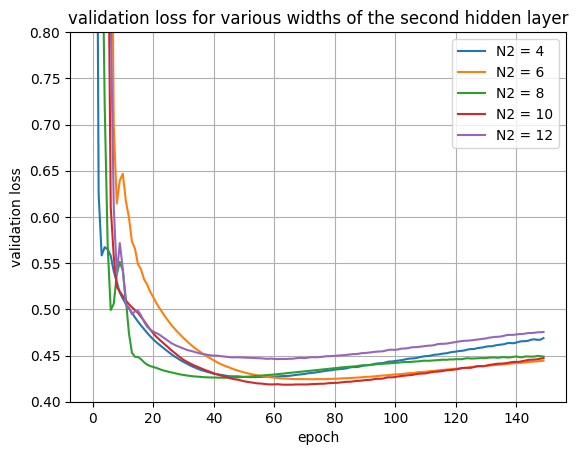

In [35]:
plt.figure()
for indx in range(len(N2_values)):
    N2=N2_values[indx]
    val_loss = two_layers_history_list[indx].history['val_loss']
    plt.plot(val_loss,label=f'N2 = {N2}')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.ylim(0.4,0.8)
plt.title(f'validation loss for various widths of the second hidden layer')
plt.show() 

N2=10 is the best choice

In [36]:
best_N2 = 10

Checking the test accuracy of the the best two hidden layers model and compariong it to the best single hidden layer model

In [37]:
N1=best_N1
N2 = best_N2
print('N1 = ',N1,' N2 = ',N2)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
best_two_layer_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(N2, activation='relu'),  # Second Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
best_two_layer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_two_layer_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val),
                         verbose=0,callbacks=[best_weight_saver])

N1 =  60  N2 =  10
Restored best weights from epoch 66 with val_loss: 0.4183


In [38]:
y_pred_test = best_two_layer_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [39]:
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
best_two_layer_acc_test =   accuracy_score  (y_test, y_dec_test)
best_two_layer_rec_test =   recall_score    (y_test, y_dec_test)
best_two_layer_prec_test =  precision_score (y_test, y_dec_test)
best_two_layer_f1_test =    f1_score        (y_test, y_dec_test)
print('best single layer model versus best two layers model test preformances')
print('----------------------------------------------------------------------')
print('metric      single      two')
print(f"Accuracy    {best_single_layer_acc_test:.2f}       {best_two_layer_acc_test:.2f}")
print(f"Recall      {best_single_layer_rec_test:.2f}       {best_two_layer_rec_test:.2f}")
print(f"Precision   {best_single_layer_prec_test:.2f}       {best_two_layer_prec_test:.2f}")
print(f"F1-Score    {best_single_layer_f1_test:.2f}       {best_two_layer_f1_test:.2f}")

best single layer model versus best two layers model test preformances
----------------------------------------------------------------------
metric      single      two
Accuracy    0.82       0.82
Recall      0.91       0.91
Precision   0.78       0.78
F1-Score    0.84       0.84


The performances of the best two hidden layer model are the same as those of the best single layer model.   

******Three hidden layer model******

Adding a third hidden layer with widths: 16,20,24,28,32,36

In [40]:
three_layers_history_list = []
N1 = best_N1
N2 = best_N2
N3_values = [16,20,24,28,32,36]
for indx in range(len(N3_values)):
    N3=N3_values[indx]
    print('N1 =',N1,'N2 =',N2,'N3 =',N3)
    seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
    best_weight_saver = BestWeightSaver()
    three_layers_model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),  # Input layer
        layers.Dense(N1, activation='relu'),  # first hidden layer
        layers.Dense(N2, activation='relu'),  # second hidden layer
        layers.Dense(N3, activation='relu'),  # third hidden layer
        layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
    three_layers_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    three_layers_history = three_layers_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val)
                                                  ,verbose=0,callbacks=[best_weight_saver])
    three_layers_history_list.append(three_layers_history)

N1 = 60 N2 = 10 N3 = 16
Restored best weights from epoch 55 with val_loss: 0.4214
N1 = 60 N2 = 10 N3 = 20
Restored best weights from epoch 41 with val_loss: 0.4193
N1 = 60 N2 = 10 N3 = 24
Restored best weights from epoch 67 with val_loss: 0.4240
N1 = 60 N2 = 10 N3 = 28
Restored best weights from epoch 68 with val_loss: 0.4127
N1 = 60 N2 = 10 N3 = 32
Restored best weights from epoch 69 with val_loss: 0.4182
N1 = 60 N2 = 10 N3 = 36
Restored best weights from epoch 70 with val_loss: 0.4383


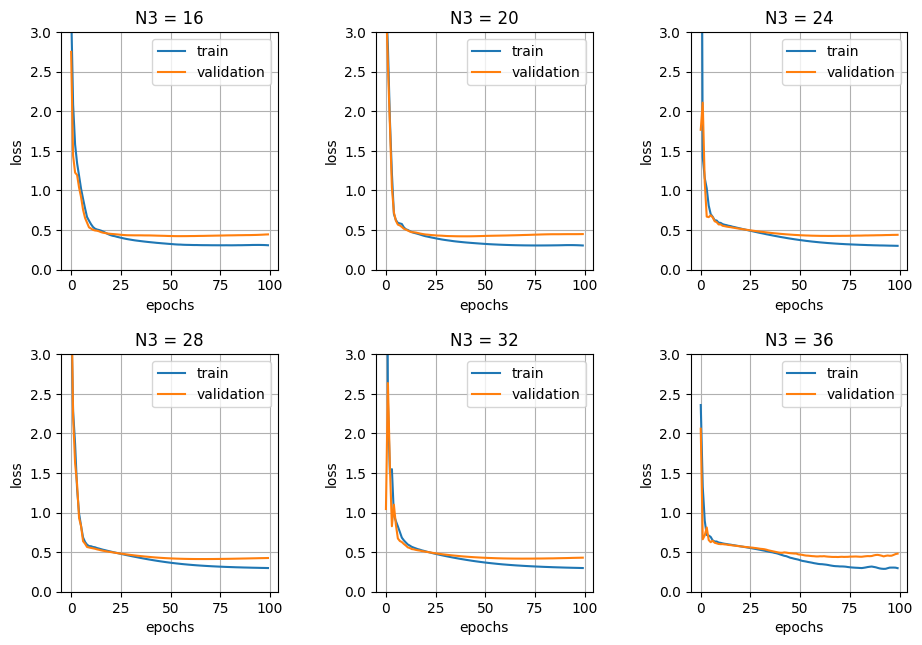

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.tight_layout(pad=4.0)
for indx in range(len(N3_values)):
    N3=N3_values[indx]
    ax = axes[indx//3, indx%3]
    train_loss = three_layers_history_list[indx].history['loss']
    val_loss = three_layers_history_list[indx].history['val_loss']
    ax.plot(train_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_ylim([0, 3])
    ax.grid()
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_title(f'N3 = {N3}')
plt.show() 

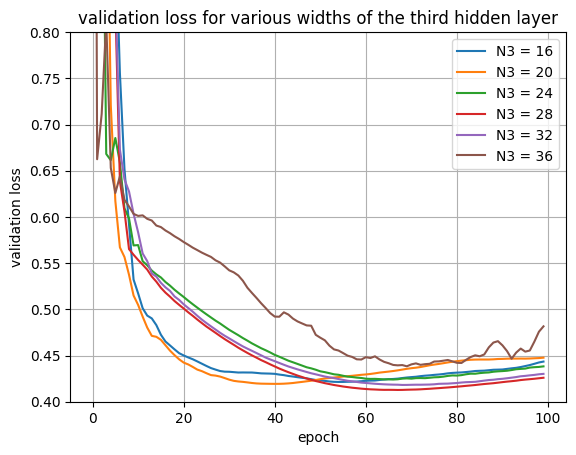

In [42]:
plt.figure()
for indx in range(len(N3_values)):
    N3=N3_values[indx]
    val_loss = three_layers_history_list[indx].history['val_loss']
    plt.plot(val_loss,label=f'N3 = {N3}')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.ylim(0.4,0.8)
plt.title(f'validation loss for various widths of the third hidden layer')
plt.show() 

We shall choose N3 = 28   

Checking the test accuracy of the best three hidden layers model and compariong it to the best one and two hidden layer models

In [43]:
best_N3 =28

In [44]:
N1=best_N1
N2=best_N2
N3=best_N3
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
best_three_layer_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(N2, activation='relu'),  # Second Hidden layer
    layers.Dense(N3, activation='relu'),  # third Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
best_three_layer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_three_layer_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val),
                           verbose=0,callbacks=[best_weight_saver])

Restored best weights from epoch 68 with val_loss: 0.4127


In [45]:
y_pred_test = best_three_layer_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [46]:
print('prediction completed')

prediction completed


In [47]:
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
best_three_layer_acc_test =   accuracy_score  (y_test, y_dec_test)
best_three_layer_rec_test =   recall_score    (y_test, y_dec_test)
best_three_layer_prec_test =  precision_score (y_test, y_dec_test)
best_three_layer_f1_test =    f1_score        (y_test, y_dec_test)

In [48]:
print('best single, two, and three layer models preformances')
print('-----------------------------------------------------')
print('metric      single      two       three')
print(f"Accuracy    {best_single_layer_acc_test:.2f}       {best_two_layer_acc_test:.2f}       {best_three_layer_acc_test:.2f}")
print(f"Recall      {best_single_layer_rec_test:.2f}       {best_two_layer_rec_test:.2f}       {best_three_layer_rec_test:.2f}")
print(f"Precision   {best_single_layer_prec_test:.2f}       {best_two_layer_prec_test:.2f}       {best_three_layer_prec_test:.2f}")
print(f"F1-Score    {best_single_layer_f1_test:.2f}       {best_two_layer_f1_test:.2f}       {best_three_layer_f1_test:.2f}")

best single, two, and three layer models preformances
-----------------------------------------------------
metric      single      two       three
Accuracy    0.82       0.82       0.80
Recall      0.91       0.91       0.91
Precision   0.78       0.78       0.76
F1-Score    0.84       0.84       0.83


The performances of the best single, two, and three hidden layer models are very similar.   
We shell select the single hidden layer model as the best ANN model, because of its lower complexity  

In [49]:
BNN = best_single_layer_model
BNN_acc_test=best_single_layer_acc_test
BNN_rec_test=best_single_layer_rec_test
BNN_prec_test=best_single_layer_prec_test
BNN_f1_test=best_single_layer_f1_test

**10+11) Modifying the training set** 

__Trying to improve the performances by removing potential outliers__   

The potential outliers are determined by their loss

In [50]:
y_pred_train = BNN.predict(X_train)
loss_fn = BinaryCrossentropy(reduction='none')
sample_losses = loss_fn(y_train.values, y_pred_train).numpy()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


__Trying to remove 30% of the potential outliers__

In [51]:
outliers_percentage = 30
outliers_threshold = np.percentile(sample_losses, 100-outliers_percentage)
outliers_idx = X_train.index[np.where(sample_losses >= outliers_threshold)[0]]
print(f"{len(outliers_idx)} potential outliers detected")

55 potential outliers detected


Remove the potential outliers from the training set and training a model on the modified tarining set 

In [52]:
X_train_R30 = X_train.drop(index=outliers_idx)
y_train_R30 = y_train.drop(index=outliers_idx)
N1 = best_N1
print('N1 = ', N1)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
BNN_R30 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
BNN_R30.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_R30.fit(X_train_R30, y_train_R30, epochs=75, batch_size=32,validation_data=(X_val, y_val),
                                                  verbose=0,callbacks=[best_weight_saver])

N1 =  60
Restored best weights from epoch 45 with val_loss: 0.4255


Check the performances of the modified model

In [55]:
y_pred_test = BNN_R30.predict(X_test)
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
BNN_R30_acc_test =   accuracy_score  (y_test, y_dec_test)
BNN_R30_rec_test =   recall_score    (y_test, y_dec_test)
BNN_R30_prec_test =  precision_score (y_test, y_dec_test)
BNN_R30_f1_test =    f1_score        (y_test, y_dec_test)
print('preformances before and after removing 30% of the potential outliers')
print('--------------------------------------------------------------------')
print('metric      before     after')
print(f"Accuracy    {best_single_layer_acc_test:.2f}       {BNN_R30_acc_test:.2f}")
print(f"Recall      {best_single_layer_rec_test:.2f}       {BNN_R30_rec_test:.2f}")
print(f"Precision   {best_single_layer_prec_test:.2f}       {BNN_R30_prec_test:.2f}")
print(f"F1-Score    {best_single_layer_f1_test:.2f}       {BNN_R30_f1_test:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
preformances before and after removing 30% of the potential outliers
--------------------------------------------------------------------
metric      before     after
Accuracy    0.82       0.77
Recall      0.91       0.91
Precision   0.78       0.72
F1-Score    0.84       0.81


__Trying to remove only 3% of the potential outliers__

In [56]:
outliers_percentage = 3
outliers_threshold = np.percentile(sample_losses, 100-outliers_percentage)
outliers_idx = X_train.index[np.where(sample_losses >= outliers_threshold)[0]]
print(f"{len(outliers_idx)} potential outliers detected")

6 potential outliers detected


Remove the potential outliers from the training set and training a model on the modified tarining set 

In [57]:
X_train_R3 = X_train.drop(index=outliers_idx)
y_train_R3 = y_train.drop(index=outliers_idx)
N1 = best_N1
print('N1 = ', N1)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
BNN_R3 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
BNN_R3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_R3.fit(X_train_R3, y_train_R3, epochs=75, batch_size=32,validation_data=(X_val, y_val),
                                                  verbose=0,callbacks=[best_weight_saver])

N1 =  60
Restored best weights from epoch 32 with val_loss: 0.4459


Check the performances of the modified model

In [58]:
y_pred_test = BNN_R3.predict(X_test)
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
BNN_R3_acc_test =   accuracy_score  (y_test, y_dec_test)
BNN_R3_rec_test =   recall_score    (y_test, y_dec_test)
BNN_R3_prec_test =  precision_score (y_test, y_dec_test)
BNN_R3_f1_test =    f1_score        (y_test, y_dec_test)
print('preformances before and after removing 3% of the potential outliers')
print('--------------------------------------------------------------------')
print('metric      before     after')
print(f"Accuracy    {best_single_layer_acc_test:.2f}       {BNN_R3_acc_test:.2f}")
print(f"Recall      {best_single_layer_rec_test:.2f}       {BNN_R3_rec_test:.2f}")
print(f"Precision   {best_single_layer_prec_test:.2f}       {BNN_R3_prec_test:.2f}")
print(f"F1-Score    {best_single_layer_f1_test:.2f}       {BNN_R3_f1_test:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
preformances before and after removing 3% of the potential outliers
--------------------------------------------------------------------
metric      before     after
Accuracy    0.82       0.82
Recall      0.91       0.88
Precision   0.78       0.80
F1-Score    0.84       0.84


__Removing only 3% of the potential outliers slitly improves the precision but degrads the recall __

**12) Changing the architecture**

The network is very simple, and there is no rome for architectural changes.
We shall try utilizing dropout.

In [60]:
N1 = best_N1
print('N1 = ', N1)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
BNN_DRP = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
BNN_DRP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_DRP_history=BNN_DRP.fit(X_train, y_train, epochs=150, batch_size=32,validation_data=(X_val, y_val),
                            verbose=0,callbacks=[best_weight_saver])

N1 =  60
Restored best weights from epoch 146 with val_loss: 0.4282


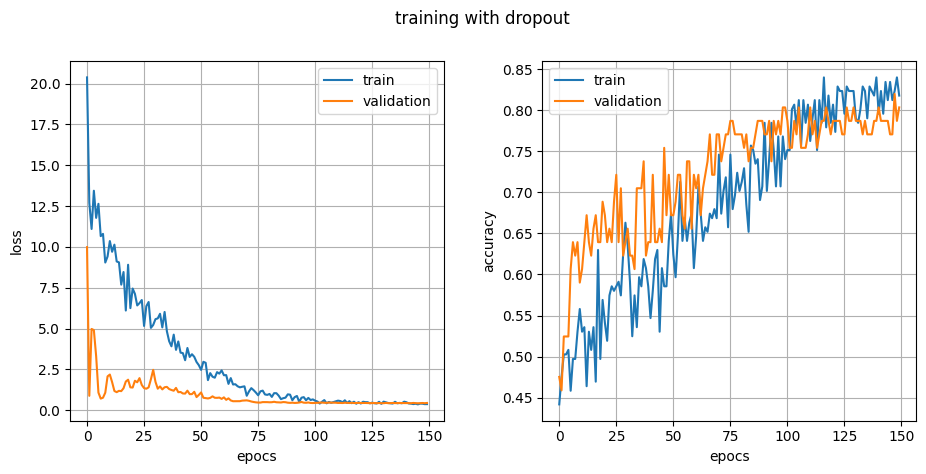

In [61]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
fig.tight_layout(pad=4.0)
ax = axes[0]
ax.plot(BNN_DRP_history.history['loss'], label='train')
ax.plot(BNN_DRP_history.history['val_loss'], label='validation')
ax.grid()
ax.legend()
ax.set_xlabel('epocs')
ax.set_ylabel('loss')
ax=axes[1]
ax.plot(BNN_DRP_history.history['accuracy'], label='train')
ax.plot(BNN_DRP_history.history['val_accuracy'], label='validation')
ax.grid()
ax.legend()
ax.set_xlabel('epocs')
ax.set_ylabel('accuracy')
plt.suptitle('training with dropout')
plt.show()

In [62]:
y_pred_test = BNN_DRP.predict(X_test)
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
BNN_DRP_acc_test =   accuracy_score  (y_test, y_dec_test)
BNN_DRP_rec_test =   recall_score    (y_test, y_dec_test)
BNN_DRP_prec_test =  precision_score (y_test, y_dec_test)
BNN_DRP_f1_test =    f1_score        (y_test, y_dec_test)
print('The effect of dropout on the performance')
print('----------------------------------------')
print('metric      original     dropout')
print(f"Accuracy    {BNN_acc_test:.2f}       {BNN_DRP_acc_test:.2f}")
print(f"Recall      {BNN_rec_test:.2f}       {BNN_DRP_rec_test:.2f}")
print(f"Precision   {BNN_prec_test:.2f}       {BNN_DRP_prec_test:.2f}")
print(f"F1-Score    {BNN_f1_test:.2f}       {BNN_DRP_f1_test:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The effect of dropout on the performance
----------------------------------------
metric      original     dropout
Accuracy    0.82       0.82
Recall      0.91       0.91
Precision   0.78       0.78
F1-Score    0.84       0.84


__Dropout does not affect the performances__

**13) Utilizing the Hinge loss function**

In [63]:
y_train_hinge = y_train.replace(0, -1)
y_val_hinge = y_val.replace(0, -1)
y_test_hinge = y_test.replace(0, -1)

In [64]:
N1 = best_N1
print('N1 = ', N1)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
hinge_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='linear')  # Output layer (sigmoid for binary classification)
    ])
hinge_model.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])
hinge_history = hinge_model.fit(X_train, y_train_hinge, epochs=75, batch_size=32,validation_data=(X_val, y_val_hinge),
                                                  verbose=0,callbacks=[best_weight_saver])

N1 =  60
Restored best weights from epoch 29 with val_loss: 0.4562


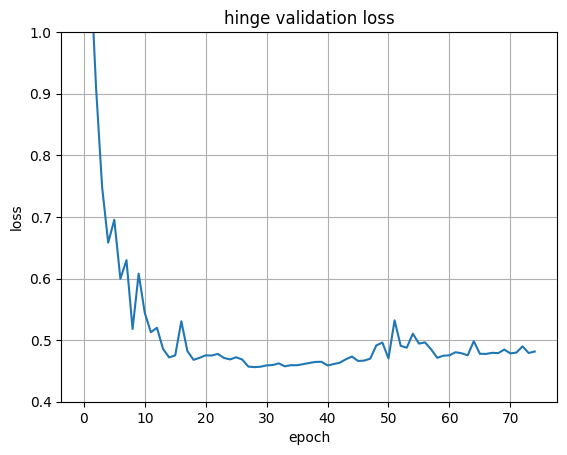

In [65]:
plt.figure()
val_loss = hinge_history.history['val_loss']
plt.plot(val_loss)
plt.grid()
plt.ylim(0.4,1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'hinge validation loss')
plt.show()

In [66]:
decision_threshold = 0
y_pred_test = hinge_model.predict(X_test)
y_dec_test = y_pred_test>=decision_threshold
hinge_acc_test =   accuracy_score  (y_test, y_dec_test)
hinge_rec_test =   recall_score    (y_test, y_dec_test)
hinge_prec_test =  precision_score (y_test, y_dec_test)
hinge_f1_test =    f1_score        (y_test, y_dec_test)
print('hinge model test preformances')
print('metric      value')
print('-----------------')
print(f"Accuracy    {hinge_acc_test:.2f}")
print(f"Recall      {hinge_rec_test:.2f}")
print(f"Precision   {hinge_prec_test:.2f}")
print(f"F1-Score    {hinge_f1_test:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
hinge model test preformances
metric      value
-----------------
Accuracy    0.82
Recall      0.91
Precision   0.78
F1-Score    0.84


The performances with the Hinge activation function are similar to those with the binary entropy one

**14) Changing the balance of the data set** 

The data set is well balanced: the negative/positive output ratio is 0.46/0.54.
Therefore, changing the balance is expected to deterirate the performances.

*****Moderate imbalance***** 

Removing 50% of the positive-target samples from the trainning and validation sets

In [67]:
p=0.5
positive_indices = y_train[y_train == 1].index.to_numpy()
num_to_remove = int(p * len(positive_indices))
rows_to_remove = np.random.choice(positive_indices, num_to_remove, replace=False)
y_R1_train = y_train.drop(rows_to_remove)
X_R1_train = X_train.drop(rows_to_remove)
positive_indices = y_val[y_val == 1].index.to_numpy()
num_to_remove = int(p * len(positive_indices))
rows_to_remove = np.random.choice(positive_indices, num_to_remove, replace=False)
y_R1_val = y_val.drop(rows_to_remove)
X_R1_val = X_val.drop(rows_to_remove)

Training the best ANN on the modified data set 

In [68]:
N1=best_N1
N2=best_N2
N3=best_N3
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
BNN_R1_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(N2, activation='relu'),  # Second Hidden layer
    layers.Dense(N3, activation='relu'),  # third Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
BNN_R1_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_R1_model.fit(X_R1_train, y_R1_train, epochs=150, batch_size=32, validation_data=(X_R1_val, y_R1_val),
                           verbose=0,callbacks=[best_weight_saver])

Restored best weights from epoch 77 with val_loss: 0.4702


In [69]:
y_pred_test = BNN_R1_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [70]:
print('prediction completed')

prediction completed


In [71]:
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
BNN_R1_acc_test =   accuracy_score  (y_test, y_dec_test)
BNN_R1_rec_test =   recall_score    (y_test, y_dec_test)
BNN_R1_prec_test =  precision_score (y_test, y_dec_test)
BNN_R1_f1_test =    f1_score        (y_test, y_dec_test)

In [72]:
print('Original versus modified data set')
print('---------------------------------')
print('metric      original      modified')
print(f"Accuracy    {BNN_acc_test:.2f}       {BNN_R1_acc_test:.2f}")
print(f"Recall      {BNN_rec_test:.2f}       {BNN_R1_rec_test:.2f}")
print(f"Precision   {BNN_prec_test:.2f}       {BNN_R1_prec_test:.2f}")
print(f"F1-Score    {BNN_f1_test:.2f}       {BNN_R1_f1_test:.2f}")

Original versus modified data set
---------------------------------
metric      original      modified
Accuracy    0.82       0.77
Recall      0.91       0.78
Precision   0.78       0.78
F1-Score    0.84       0.78


In [73]:
print('The positive outcome rate in the training set is ',np.mean(y_R1_train))

The positive outcome rate in the training set is  0.3893129770992366


The dataset is moderately imbalanced.   
The recall was highly degraded, while the precision is not affected.   
Consequently,the accuracy and the F1 score are also degraded.  

*****High imbalance***** 

Removing 90% of the positive-target samples from the trainning and validation sets

In [74]:
p=0.90
positive_indices = y_train[y_train == 1].index.to_numpy()
num_to_remove = int(p * len(positive_indices))
rows_to_remove = np.random.choice(positive_indices, num_to_remove, replace=False)
y_R2_train = y_train.drop(rows_to_remove)
X_R2_train = X_train.drop(rows_to_remove)
positive_indices = y_val[y_val == 1].index.to_numpy()
num_to_remove = int(p * len(positive_indices))
rows_to_remove = np.random.choice(positive_indices, num_to_remove, replace=False)
y_R2_val = y_val.drop(rows_to_remove)
X_R2_val = X_val.drop(rows_to_remove)

Training the best ANN on the modified data set 

In [75]:
N1=best_N1
N2=best_N2
N3=best_N3
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
BNN_R2_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(N2, activation='relu'),  # Second Hidden layer
    layers.Dense(N3, activation='relu'),  # third Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
BNN_R2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_R2_model.fit(X_R2_train, y_R2_train, epochs=150, batch_size=32, validation_data=(X_R2_val, y_R2_val),
                           verbose=0,callbacks=[best_weight_saver])

Restored best weights from epoch 147 with val_loss: 0.3277


In [76]:
y_pred_test = BNN_R2_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [77]:
print('prediction completed')

prediction completed


In [78]:
decision_threshold = 0.5
y_dec_test = y_pred_test>=decision_threshold
BNN_R2_acc_test =   accuracy_score  (y_test, y_dec_test)
BNN_R2_rec_test =   recall_score    (y_test, y_dec_test)
BNN_R2_prec_test =  precision_score (y_test, y_dec_test)
BNN_R2_f1_test =    f1_score        (y_test, y_dec_test)

In [79]:
print('Original versus modified data set')
print('---------------------------------')
print('metric      original      modified')
print(f"Accuracy    {BNN_acc_test:.2f}       {BNN_R2_acc_test:.2f}")
print(f"Recall      {BNN_rec_test:.2f}       {BNN_R2_rec_test:.2f}")
print(f"Precision   {BNN_prec_test:.2f}       {BNN_R2_prec_test:.2f}")
print(f"F1-Score    {BNN_f1_test:.2f}       {BNN_R2_f1_test:.2f}")

Original versus modified data set
---------------------------------
metric      original      modified
Accuracy    0.82       0.64
Recall      0.91       0.44
Precision   0.78       0.78
F1-Score    0.84       0.56


In [80]:
print('The positive outcome rate in the training set is ',np.mean(y_R2_train))

The positive outcome rate in the training set is  0.12087912087912088


The dataset is highly imbalanced.   
The recall was completely degraded, while the precision is not affected.   
Consequently,the accuracy and the F1 score are also highly degraded.  

**15) Dimmension reduction**

*****Removing non correlated predictors*****

Removing the for predictors trestbps, restecg, chol, and fbs, which have the lowest correlation with the target, from the dataset

In [81]:
X1=X.drop(columns=['trestbps','restecg_1','restecg_2','chol','fbs'])
y1=y.copy()

In [82]:
X1_train, X1_full_test, y1_train, y1_full_test = train_test_split(X1, y1, test_size=0.4,random_state=503)
X1_val, X1_test, y1_val,y1_test = train_test_split(X1_full_test, y1_full_test, test_size=0.5,random_state=419)

In [83]:
N1 = best_N1
print('N1 = ', N1)
seed = 185; random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
best_weight_saver = BestWeightSaver()
BNN_DR = keras.Sequential([
    layers.Input(shape=(X1_train.shape[1],)),  # Input layer
    layers.Dense(N1, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer (sigmoid for binary classification)
    ])
BNN_DR.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BNN_DR.fit(X1_train, y1_train, epochs=150, batch_size=32,validation_data=(X1_val, y1_val),
                                                  verbose=0,callbacks=[best_weight_saver])

N1 =  60
Restored best weights from epoch 61 with val_loss: 0.4288


In [84]:
y_pred = BNN_DR.predict(X1_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [85]:
decision_threshold = 0.5
y_pred_dec = y_pred>decision_threshold
BNN_DR_acc = accuracy_score(y1_test, y_pred_dec)
BNN_DR_prec = precision_score(y1_test, y_pred_dec)
BNN_DR_rec = recall_score(y1_test, y_pred_dec)
BNN_DR_f1 = f1_score(y1_test, y_pred_dec)
print('Comparing the performance metrics before and after removing non-correlated predictors')
print('-------------------------------------------------------------------------------------')
print('before         after')
print(f"Accuracy:  {BNN_acc_test:.2}       {BNN_DR_acc:.2}")
print(f"Recall:    {BNN_rec_test:.2}       {BNN_DR_rec:.2}")
print(f"Precision: {BNN_prec_test:.2}       {BNN_DR_prec:.2f}")
print(f"F1-Score:  {BNN_f1_test:.2}       {BNN_DR_f1:.2f}")

Comparing the performance metrics before and after removing non-correlated predictors
-------------------------------------------------------------------------------------
before         after
Accuracy:  0.82       0.8
Recall:    0.91       0.88
Precision: 0.78       0.78
F1-Score:  0.84       0.82


Even the predictors with the lowest correlation contribute something to the performances of the model.   
Therefore, removing them is not a good choice for dimension reduction.   
Since the number of dimensions is relatively low (13) and the size of the network is relatively low, there is no much insentive to reduce the number of dimmensions.